<h2> Import Packages </h2>

In [2]:
import numpy as np
import tensorflow as tf
import keras
import scipy.misc as sm
import cv2
import matplotlib.pyplot as plt
import time
import keras.backend as K
import os.path
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras import losses
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import warnings
warnings.filterwarnings("ignore")
from keras.preprocessing import image
from keras.models import load_model


<h2> Create Memory Map </h2>

In [3]:
original_X = np.memmap('./original_X.dat', dtype = np.float32, mode = 'r+', shape = (22424, 224, 224, 3))
original_Y = np.memmap('./original_Y.dat', dtype = np.float32, mode = 'r+', shape = (22424, 1))

<h2> Read CSV File For Image List </h2>

In [4]:
csvList = np.genfromtxt('./imageList.csv', delimiter = ',', dtype = str)

<h2> Read Images Into Memory Map </h2>
<p> (Images Are Normalised And Downsized While Being Read) </p>

In [5]:
def readImages():
    
    for i in range (22424):
        imagePath = "./train/" + csvList[i][0] + "/" + csvList[i][1]
        inputImage = sm.imread(imagePath)
        inputImageResized = sm.imresize(inputImage, (224, 224))
        
        # Normalise values to between 0 ans 1
        original_X[i] = inputImageResized / 255
        original_Y[i] = csvList[i][0][1]
        
        if (i % 50 == 0):
            print ("Images Read : ", i)

In [ ]:
start = time.time()
readImages()
stop = time.time()
print ("22424 Images Read in ", stop - start, " Seconds.")

<h2> Convert Y To One Hot Encoded Form </h2>


In [6]:
def computeOneHot(labels, depth):
    
    c = tf.constant(depth, name = "depth")
    
    # Compute One Hot Encoding
    oneHot = tf.one_hot(labels, c, axis = 0)
    
    # Run Tensor Flow Session
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        oneHotMatrix = sess.run(oneHot)
        sess.close()
    
    return oneHotMatrix

<h2> Data About Data</h2>

In [7]:
# Compute One Hot Encoding Of Y
oneHot_Y = computeOneHot(original_Y, 10)
oneHot_Y = oneHot_Y.reshape(10, 22424).T

print ("Shape Of X : ", original_X.shape)
print ("Shape Of Y : ", oneHot_Y.shape)
print ("\nNumber Of Images : ", original_X.shape[0])
print ("Size Of Each Image : ", original_X.shape[1], "x", original_X.shape[2], "x", original_X.shape[3])
print ("\nNumber Of Images : ", original_X.shape[0])
print ("Number Of Classes : ", oneHot_Y.shape[1])

print ("\nNumber Of Examples In Each Class : ")


# Initialise Class Counts
c0, c1, c2, c3, c4, c5, c6, c7, c8, c9 = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

for i in range (22424):
    
    if original_Y[i] == 0:
        c0 = c0 + 1
    if original_Y[i] == 1:
        c1 = c1 + 1
    if original_Y[i] == 2:
        c2 = c2 + 1
    if original_Y[i] == 3:
        c3 = c3 + 1
    if original_Y[i] == 4:
        c4 = c4 + 1
    if original_Y[i] == 5:
        c5 = c5 + 1
    if original_Y[i] == 6:
        c6 = c6 + 1
    if original_Y[i] == 7:
        c7 = c7 + 1
    if original_Y[i] == 8:
        c8 = c8 + 1
    if original_Y[i] == 9:
        c9 = c9 + 1
        
print (c0, c1, c2, c3, c4, c5, c6, c7, c8, c9)

Shape Of X :  (22424, 224, 224, 3)
Shape Of Y :  (22424, 10)

Number Of Images :  22424
Size Of Each Image :  224 x 224 x 3

Number Of Images :  22424
Number Of Classes :  10

Number Of Examples In Each Class : 
2489 2267 2317 2346 2326 2312 2325 2002 1911 2129


<h2> Visualise The Data Set </h2>

Category :   7
Image :  img_34020.jpg


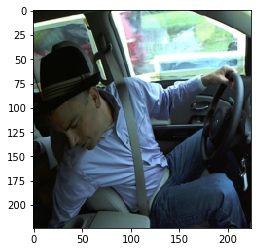

Y Label :  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [8]:
i = 7777
print ("Category :  ", csvList[i][0][1])
print ("Image : ", csvList[i][1])
plt.imshow(original_X[i])
plt.show()
print ("Y Label : ", oneHot_Y[i, :])


<h1> Basic Convolutional Neural Network Using Keras </h1>

In [8]:
def basicCNNModel (inputShape):
    
    # Input 
    X_Input = Input(inputShape)
    
    # Zero Pad
    X = ZeroPadding2D((3, 3))(X_Input)
    
    # Convolution Layer 1
    X = Conv2D(32, (3, 3), strides = (1, 1), name = 'conv0')(X)
    X = Activation('relu')(X)
    
    # MaxPool Layer 1
    X = MaxPooling2D((2, 2))(X)
    
    # Drop Out Layer 1
#     X = Dropout(0.2)(X)
    
    # Convolution Layer 2
    X = Conv2D(32, (3, 3), strides = (1, 1), name = 'conv1')(X)
    X = Activation('relu')(X)
    
    # MaxPool Layer 2
    X = MaxPooling2D((2, 2))(X)
    
    # Dropout Layer 2
#     X = Dropout(0.2)(X)
    
    # Convolution Layer 3
    X = Conv2D(64, (3, 3), strides = (1, 1), name = 'conv2')(X)
    X = Activation('relu')(X)
    
    # MaxPool Layer 3
    X = MaxPooling2D((2, 2))(X)
    
    # Drop Out Layer 3
#     X = Dropout(0.3)(X)
    
    # Flatten X
    X = Flatten()(X)
    
    # Fully Connected Layer 1
    X = Dense(64, activation = 'relu', name = 'fc0')(X)
    
    # Drop Out Layer 4
    X = Dropout(0.3)(X)
    
    # Fully Connected Layer 1
    X = Dense(10, activation = 'softmax', name = 'fc1')(X)
    
    # Model
    model = Model(inputs = X_Input, outputs = X, name = 'BasicCNN')
    
    return model

<h2> Define A Data Generator To Augment Data </h2>

In [32]:
trainDataGen = ImageDataGenerator (rotation_range = 15,
                              width_shift_range = 0.1, 
                              height_shift_range = 0.2, 
                              zoom_range = 0.0, 
                              fill_mode = 'nearest')

<h2> Visualise Augmented Data </h2>
<p> (Augmented Data Is Stored On Disk Upon Running The Code Below) </p>

In [32]:
i = 0
for batch in trainDataGen.flow(original_X[10:15], batch_size = 1, save_to_dir = 'Augmented', save_prefix = 'Aug', save_format = 'jpeg'):
    i = i + 1
    if i == 10:
        break

<h2> Create A Train Generator </h2> 

In [10]:
# Get Data Directly From Disk And Augment (Gives Horrid Accuracy For Some Reason)

# trainGenerator = trainDataGen.flow_from_directory('./train', 
#                                                   target_size = (224, 224), 
#                                                   classes = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'], 
#                                                   class_mode = 'categorical')

# Augment Imported Data

trainGenerator = trainDataGen.flow(original_X, oneHot_Y, batch_size = 32)

In [11]:
# Get The Model
model = basicCNNModel((original_X.shape[1], original_X.shape[2], original_X.shape[3]))

# Compile The Model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [11]:
# Train The Model

# model.fit(x = original_X, y = oneHot_Y, epochs = 3, batch_size = 32)
model.fit_generator(trainGenerator, steps_per_epoch = 22424 // 32, epochs = 2)

Epoch 1/2
700/700 [==============================] - 1469s 2s/step - loss: 1.6418 - acc: 0.3978
Epoch 2/2
700/700 [==============================] - 1429s 2s/step - loss: 0.9912 - acc: 0.6340


In [14]:
# Save Weights
model.save_weights('BasicCNNEpochTwo.h5')

In [23]:
# Load Weights If Needed
model.load_weights('BasicCNNWeightsEpochTen.h5')

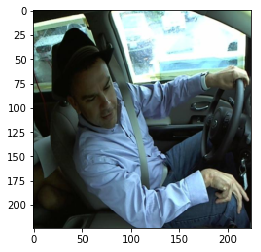

True Label :  9
Predicted :  9


In [24]:
# Predict On Train Set 
i = 7969
imTrainPath = "./train/" + csvList[i][0] + "/" + csvList[i][1]

trainImage = sm.imread(imTrainPath)
trainImage = sm.imresize(trainImage, (224, 224))
trainImage = trainImage / 255
trainImage = trainImage.astype(np.float32)

plt.imshow(trainImage)
plt.show()

trainImage = np.expand_dims(trainImage, axis = 0)

print ("True Label : ", int(original_Y[i]))
print("Predicted : ", np.argmax(model.predict(trainImage)))

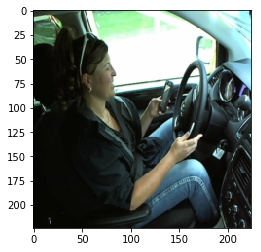

Predicted :  3


In [30]:
# Predict On Test Set 
i = 1345
imTestPath = "./test/img_" + str(i) + ".jpg"
testImage = sm.imread(imTestPath)
testImage = sm.imresize(testImage, (224, 224))
testImage = testImage / 255
testImage = testImage.astype(np.float32)

plt.imshow(testImage)
plt.show()

testImage = np.expand_dims(testImage, axis = 0)

print("Predicted : ", np.argmax(model.predict(testImage)))


In [33]:
pred = model.evaluate (original_X, oneHot_Y)
print ("Train Set Accuracy")
print ("Loss = " + str(pred[0]))
print ("Train Accuracy = " + str(pred[1]))

22424/22424 [==============================] - 1165s 52ms/step
Train Set Accuracy
Loss = 0.18387321003057802
Train Accuracy = 0.9419372101320014


In [184]:
# Save The Model
model.save('./BasicCNN.h5')

<h2> Import Test Images </h2>

In [15]:
test_X = np.memmap('./test_X.dat', dtype = np.float32, mode = 'r+', shape = (79727, 224, 224, 3))
test_X_Image_Names = np.memmap('./test_X_Image_Names', dtype = object, mode = 'r+', shape = (79727, 1))

In [17]:
def readTestImages():
    
    j = 0
    
    for i in range (102150):
        imageTestPath = "./test/img_" + str(i) + ".jpg"
        
        if os.path.isfile(imageTestPath):
            inputImage = sm.imread(imageTestPath)
            inputImageResized = sm.imresize(inputImage, (224, 224))
            test_X_Image_Names[j] = "img_" + str(i) + ".jpg"
            
            # Normalise values to between 0 ans 1
            test_X[j] = inputImageResized / 255
            j = j + 1
            
            if (j % 1000 == 0):
                print ("Images Read : ", j)

In [18]:
start = time.time()
readTestImages()
stop = time.time()
print ("79727 Images Read in ", stop - start, " Seconds.")

Images Read :  1000
Images Read :  2000
Images Read :  3000
Images Read :  4000
Images Read :  5000
Images Read :  6000
Images Read :  7000
Images Read :  8000
Images Read :  9000
Images Read :  10000
Images Read :  11000
Images Read :  12000
Images Read :  13000
Images Read :  14000
Images Read :  15000
Images Read :  16000
Images Read :  17000
Images Read :  18000
Images Read :  19000
Images Read :  20000
Images Read :  21000
Images Read :  22000
Images Read :  23000
Images Read :  24000
Images Read :  25000
Images Read :  26000
Images Read :  27000
Images Read :  28000
Images Read :  29000
Images Read :  30000
Images Read :  31000
Images Read :  32000
Images Read :  33000
Images Read :  34000
Images Read :  35000
Images Read :  36000
Images Read :  37000
Images Read :  38000
Images Read :  39000
Images Read :  40000
Images Read :  41000
Images Read :  42000
Images Read :  43000
Images Read :  44000
Images Read :  45000
Images Read :  46000
Images Read :  47000
Images Read :  48000
I

<h2> Kaggle Submission Format </h2>

In [19]:
submissionCSV = np.zeros((79727, 11), dtype = object)

In [20]:
def generateKaggleCSV ():
    
    for i in range (79727):

        imName = test_X_Image_Names[i][0]
        predVal =  (model.predict(np.expand_dims(test_X[i], axis = 0)))

        submissionCSV[i, 0] = str(imName)
        submissionCSV[i, 1:] = predVal

        if i % 100 == 0:
            print ("Test Images Predicted : ", i)

In [31]:
start = time.time()
generateKaggleCSV()
stop = time.time()
print ("79727 Images Predicted in ", stop - start, " Seconds.")
np.savetxt("submission.csv", submissionCSV, delimiter = ',', fmt = '%10s')

Test Images Predicted :  0
Test Images Predicted :  100
Test Images Predicted :  200
Test Images Predicted :  300
Test Images Predicted :  400
Test Images Predicted :  500
Test Images Predicted :  600
Test Images Predicted :  700
Test Images Predicted :  800
Test Images Predicted :  900
Test Images Predicted :  1000
Test Images Predicted :  1100
Test Images Predicted :  1200
Test Images Predicted :  1300
Test Images Predicted :  1400
Test Images Predicted :  1500
Test Images Predicted :  1600
Test Images Predicted :  1700
Test Images Predicted :  1800
Test Images Predicted :  1900
Test Images Predicted :  2000
Test Images Predicted :  2100
Test Images Predicted :  2200
Test Images Predicted :  2300
Test Images Predicted :  2400
Test Images Predicted :  2500
Test Images Predicted :  2600
Test Images Predicted :  2700
Test Images Predicted :  2800
Test Images Predicted :  2900
Test Images Predicted :  3000
Test Images Predicted :  3100
Test Images Predicted :  3200
Test Images Predicted 

Test Images Predicted :  26800
Test Images Predicted :  26900
Test Images Predicted :  27000
Test Images Predicted :  27100
Test Images Predicted :  27200
Test Images Predicted :  27300
Test Images Predicted :  27400
Test Images Predicted :  27500
Test Images Predicted :  27600
Test Images Predicted :  27700
Test Images Predicted :  27800
Test Images Predicted :  27900
Test Images Predicted :  28000
Test Images Predicted :  28100
Test Images Predicted :  28200
Test Images Predicted :  28300
Test Images Predicted :  28400
Test Images Predicted :  28500
Test Images Predicted :  28600
Test Images Predicted :  28700
Test Images Predicted :  28800
Test Images Predicted :  28900
Test Images Predicted :  29000
Test Images Predicted :  29100
Test Images Predicted :  29200
Test Images Predicted :  29300
Test Images Predicted :  29400
Test Images Predicted :  29500
Test Images Predicted :  29600
Test Images Predicted :  29700
Test Images Predicted :  29800
Test Images Predicted :  29900
Test Ima

Test Images Predicted :  53300
Test Images Predicted :  53400
Test Images Predicted :  53500
Test Images Predicted :  53600
Test Images Predicted :  53700
Test Images Predicted :  53800
Test Images Predicted :  53900
Test Images Predicted :  54000
Test Images Predicted :  54100
Test Images Predicted :  54200
Test Images Predicted :  54300
Test Images Predicted :  54400
Test Images Predicted :  54500
Test Images Predicted :  54600
Test Images Predicted :  54700
Test Images Predicted :  54800
Test Images Predicted :  54900
Test Images Predicted :  55000
Test Images Predicted :  55100
Test Images Predicted :  55200
Test Images Predicted :  55300
Test Images Predicted :  55400
Test Images Predicted :  55500
Test Images Predicted :  55600
Test Images Predicted :  55700
Test Images Predicted :  55800
Test Images Predicted :  55900
Test Images Predicted :  56000
Test Images Predicted :  56100
Test Images Predicted :  56200
Test Images Predicted :  56300
Test Images Predicted :  56400
Test Ima

79727 Images Predicted in  2786.488849401474  Seconds.


 <p> Some Testing Code </p>

[[2.5713635e-03 2.9466048e-02 2.7227384e-01 2.2481463e-03 1.9882191e-03
  1.2836448e-05 2.7685393e-02 4.8095962e-01 1.7113809e-01 1.1656410e-02]]
['img_102149.jpg']


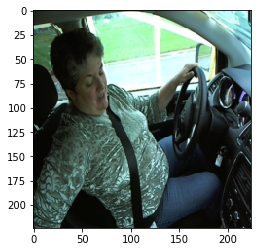

In [22]:
i = 79725
print (model.predict(np.expand_dims(test_X[i], axis = 0)))
print (test_X_Image_Names[i])
plt.imshow(test_X[i])
plt.show()